<a href="https://www.kaggle.com/code/skshmjn/pokemon-classifier-1025?scriptVersionId=213694378" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import json
from PIL import Image
from typing import Tuple,Optional

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.adamw import AdamW

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt

In [3]:
with open('/kaggle/input/pokemon-ids/pokemon_data.json', 'r') as file:
    pokedex = json.load(file)

In [4]:
idx_to_name, name_to_idx = {}, {}
for pokedex_num, item in pokedex.items():
    num = int(pokedex_num) - 1
    idx_to_name[num] = item['Name']
    name_to_idx[item['Name']] = num


In [4]:

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root,feature_extractor, transform=None, custom_class_to_idx=None,):
        super().__init__(root, transform=transform)
        self.feature_extractor = feature_extractor

        # Apply custom class_to_idx if provided
        if custom_class_to_idx:
            self.class_to_idx = name_to_idx
    
            self.samples = [(path, int(path.split('/')[-1].split('_')[0])-1) for path, class_name in self.samples]
            
    def __getitem__(self, index):
        # Get the image and label using the parent ImageFolder's __getitem__
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")  # Ensure the image is RGB

        # Apply the feature extractor to the image
        extracted_image = self.feature_extractor(images=image, return_tensors="pt")

        return extracted_image, label

In [5]:
class PokemonDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, test_dir: str, batch_size: int = 32,
                 num_workers: int = 1, img_size: Tuple[int, int] = (224, 224)):
        super().__init__()
        self.dataset = None
        self.train_dataset = None
        self.test_dataset = None
        self.val_dataset = None
        self.data_dir = data_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size
        model_name = 'imjeffhi/pokemon_classifier'
        self.feature_extractor = ViTImageProcessor.from_pretrained(model_name)

       

    def setup(self, stage: Optional[str] = None):
        # Load the full dataset and apply transforms
        self.train_dataset = CustomImageFolder(root=self.data_dir,feature_extractor = self.feature_extractor,  custom_class_to_idx=name_to_idx)
        self.dataset = CustomImageFolder(root=self.test_dir, feature_extractor = self.feature_extractor, custom_class_to_idx=name_to_idx)
        # Split dataset into train, validation, and test sets
        val_size = int(0.5 * len(self.dataset))
        test_size = int(0.5 * len(self.dataset))

        self.val_dataset, self.test_dataset = random_split(
            self.dataset, [val_size, test_size]
        )
        print(f"Training set size: {len(self.train_dataset)}")
        print(f"Validation set size: {len(self.val_dataset)}")
        print(f"Test set size: {len(self.test_dataset)}")

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers)


In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [7]:
data_module = PokemonDataModule(
        data_dir='/kaggle/input/pokemon-new/training_data',
        test_dir='/kaggle/input/pokemon-test/test_data',

        batch_size=BATCH_SIZE, img_size=IMAGE_SIZE,num_workers=4)

In [8]:
data_module.setup()

Training set size: 102491
Validation set size: 5125
Test set size: 5125


In [9]:
test_dataloader = data_module.test_dataloader()

In [10]:
data_iter = iter(test_dataloader)
first_batch = next(data_iter)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


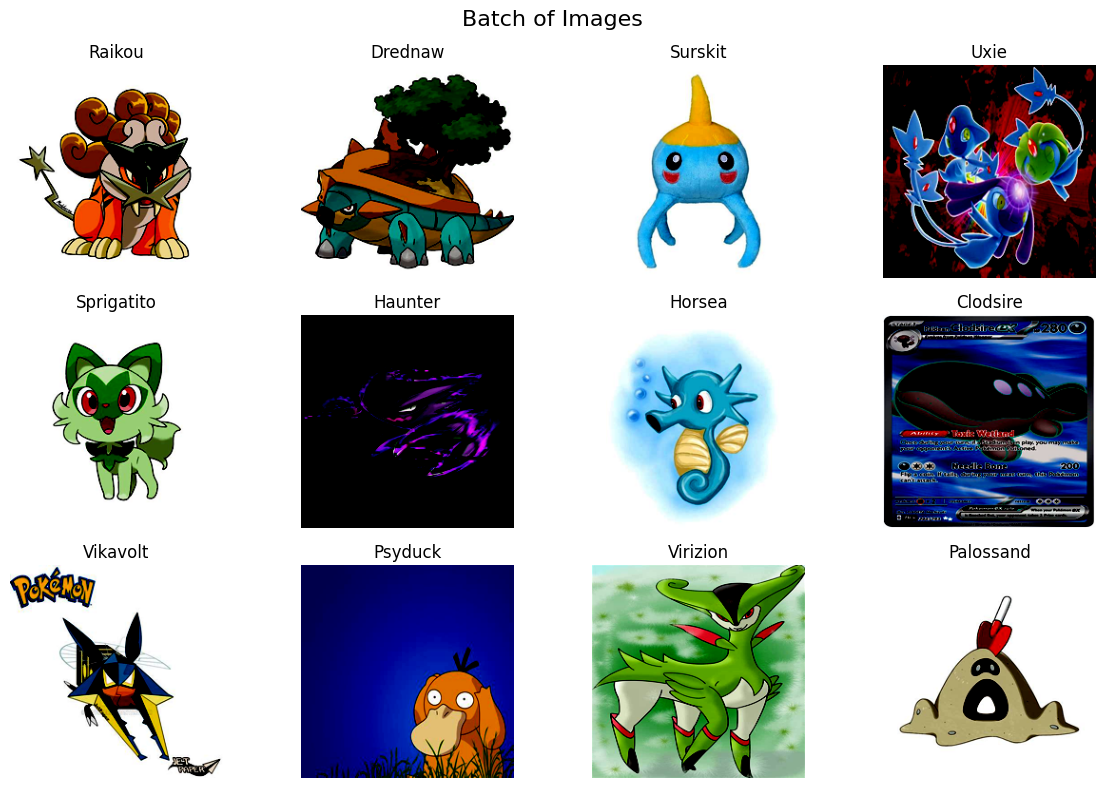

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))  # 3 rows, 4 columns for 12 images
fig.suptitle("Batch of Images", fontsize=16)

# Plot each image in the batch
for i in range(12):
    # Extract image and label
    image = first_batch[0]['pixel_values'].squeeze()[i].permute(1, 2, 0)  # Adjust dimensions
    label = idx_to_name[int(first_batch[1][i])]

    # Plot on the appropriate subplot
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [45]:
class PokemonClassifier(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(PokemonClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('imjeffhi/pokemon_classifier',
                                                             num_labels=1025,
                                                             ignore_mismatched_sizes=True,
                                                             id2label=idx_to_name,
                                                             label2id=name_to_idx)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values = batch[0]['pixel_values'].squeeze()
        labels = batch[1]
        logits = self(pixel_values)

        loss = self.criterion(logits, labels)
        
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct / pixel_values.shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("testing_loss", loss, on_epoch=False)
        self.log("testing_accuracy", accuracy, on_epoch=False)
        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5, weight_decay=0.01)


In [46]:

model = PokemonClassifier.load_from_checkpoint("/kaggle/working/checkpoints/checkpoints/pokemon-classifier-epoch=02-validation_accuracy=0.97.ckpt").to('cpu')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at imjeffhi/pokemon_classifier and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([898, 768]) in the checkpoint and torch.Size([1025, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([898]) in the checkpoint and torch.Size([1025]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
class PrintingCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # Get the training loss logged
        training_loss = trainer.callback_metrics.get("training_loss")
        training_accuracy = trainer.callback_metrics.get("training_accuracy")
        if training_loss is not None and training_accuracy is not None:
            print(f"Training - Epoch {trainer.current_epoch + 1} | Loss: {training_loss:.4f} | Accuracy: {training_accuracy:.4f}")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Get the validation loss and accuracy logged
        validation_loss = trainer.callback_metrics.get("validation_loss")
        validation_accuracy = trainer.callback_metrics.get("validation_accuracy")
        if validation_loss is not None and validation_accuracy is not None:
            print(f"Validation - Epoch {trainer.current_epoch + 1} | Loss: {validation_loss:.4f} | Accuracy: {validation_accuracy:.4f}")

    def on_test_epoch_end(self, trainer, pl_module):
        # Get the test loss and accuracy logged
        testing_loss = trainer.callback_metrics.get("testing_loss")
        testing_accuracy = trainer.callback_metrics.get("testing_accuracy")
        if testing_loss is not None and test_acc is not None:
            print(f"Test - Loss: {testing_loss:.4f} | Accuracy: {testing_accuracy:.4f}")


In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor="validation_accuracy",     # monitor validation accuracy
    dirpath="./checkpoints",    # directory to save checkpoints
    filename="pokemon-classifier-{epoch:02d}-{val_accuracy:.2f}", 
    save_top_k=3,               # save top 3 models
    mode="max"                  # maximize the monitored metric
)

early_stopping_callback = EarlyStopping(
    monitor="validation_accuracy",
    patience=2,                 # number of epochs with no improvement after which training will be stopped
    mode="max"
)

# Create the trainer
trainer = pl.Trainer(
    max_epochs=4,              # total number of epochs to train
    devices=[0],                # number of GPUs to use
    callbacks=[checkpoint_callback, early_stopping_callback,PrintingCallback()],
    accumulate_grad_batches=1,
    logger=pl.loggers.TensorBoardLogger('logs/', name='PokemonClassifier', version=0)# gradient accumulation if needed
)


In [26]:
trainer.fit(model, data_module, ckpt_path='/kaggle/working/checkpoints/checkpoints/pokemon-classifier-epoch=02-validation_accuracy=0.97.ckpt')

Training set size: 102491
Validation set size: 5125
Test set size: 5125


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from '/kaggle/working/checkpoints/checkpoints' to '/kaggle/working/checkpoints/checkpoints/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation - Epoch 3 | Loss: 0.1818 | Accuracy: 0.9688


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation - Epoch 4 | Loss: 0.1294 | Accuracy: 0.9672
Training - Epoch 4 | Loss: 0.0500 | Accuracy: 1.0000


In [34]:
feature_extractor = ViTImageProcessor.from_pretrained('imjeffhi/pokemon_classifier')

In [114]:
img = Image.open('/kaggle/input/pokemon-testing-faltu/WhatsApp Image 2024-11-29 at 16.49.11.jpeg').convert("RGB")
extracted = feature_extractor(images=img, return_tensors='pt').to('cpu')
predicted_id_1 = model1(**extracted)
predicted_ids = torch.topk(predicted_id_1.flatten(), 3).indices
# predicted_id_2 = model1(**extracted).argmax(-2).item()
# predicted_id_3 = model1(**extracted).argmax(-3).item()
# predicted_id_1

In [115]:
for i in list(predicted_ids):
    print(idx_to_name[i.item()])

Crocalor
Gurdurr
Dracovish


In [69]:
predicted_id

492

In [70]:
idx_to_name[predicted_id]

'Arceus'

In [59]:
# model1 = torch.load('/kaggle/working/pokemon_classifier_1025.pth', weights_only=False).to('cpu')

In [49]:
# directory = '/kaggle/input/pokemon-images-and-types/images'
# for i in os.listdir(directory):
#     img = Image.open(directory + '/' + i).convert("RGB")
#     extracted = feature_extractor(images=img, return_tensors='pt').to('cpu')
#     predicted_id = model(**extracted).argmax(-1).item()
#     predicted_name = idx_to_name[predicted_id].lower()
#     actual_name = i.split('.')[0]
    
#     if predicted_name != actual_name:
#         print(predicted_name, actual_name)
    
    

shaymin shaymin-land
tapu bulu tapu-bulu
meloetta meloetta-aria
quagsire porygon
crabrawler crabominable
farfetch'd dartrix
metang metagross
klang klinklang
nidorina nidoran-f
pansage simisage
dondozo wishiwashi-solo
flabébé flabebe
darmanitan darmanitan-standard
pumpkaboo pumpkaboo-average
aegislash aegislash-blade
giratina giratina-altered
dudunsparce dunsparce
tornadus tornadus-incarnate
tapu fini tapu-fini
mr. mime mr-mime
basculin basculin-red-striped
thundurus thundurus-incarnate
tapu koko tapu-koko
tynamo eelektross
keldeo keldeo-ordinary
marshtomp mudkip
landorus landorus-incarnate
klawf rowlet
deoxys deoxys-normal
dratini dragonair
farfetch'd farfetchd
nidoran♂ nidoran-m
wishiwashi kyogre
tapu lele tapu-lele
zygarde zygarde-50
mudbray mudsdale
meowstic meowstic-male
zigzagoon poochyena
oricorio oricorio-baile
gourgeist gourgeist-average
cranidos rampardos
helioptile heliolisk
wormadam wormadam-plant
type: null type-null
mime jr. mime-jr
obstagoon necrozma
mabosstiff shelmet
cu